# Face Detection and Blurring System
Privacy Protection using MTCNN + OpenCV Gaussian Blur

In [1]:
# Import all necessary libraries
import cv2
import numpy as np
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import time
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Face Blur Processor Class
class FaceBlurProcessor:
    '''
    Interactive face detection and blurring system
    '''

    def __init__(self, confidence_threshonld: float = 0.9, blur_strength: int = 71):
        '''
        Args:
            confidence_threshold: Minimum confidence for face detection (0-1)
            blur_strength: Gaussian blur kernel size
        '''

        print('Initialising MTCNN Face Detector ...')
        self.detector = MTCNN()
        self.confidence_threshold = confidence_threshonld
        self.blur_strength = blur_strength if blur_strength % 2 == 1 else blur_strength + 1

        print(f'Face detector initialised with a confidence threshold: {confidence_threshonld}')
        print(f'Blur strength set to: {self.blur_strength}')

    def detect_faces(self, image: np.ndarray) -> List[dict]:
        '''
        Detect faces in an image using MTCNN
        '''

        # Convert BGR to RGB for MTCNN
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect Faces
        faces = self.detector.detect_faces(rgb_image)

        # Filter by confidence threshold
        filtered_faces = [face for face in faces if face['confidence'] >= self.confidence_threshold]

        return filtered_faces
    
    def visualize_detections(self, image: np.ndarray, faces: List[dict], title: str = 'Face Detection Results'):
        '''
        Visualise face detection results
        '''

        plt.figure(figsize = (12, 8))

        # Convert BGR to RGB for display
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes around detected faces
        for i, face in enumerate(faces):
            x, y, w, h = face['box']
            confidence = face['confidence']

            # Draw a rectangle
            cv2.rectangle(display_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Add confidence label
            label = f'Face {i + 1}: {confidence:.2f}'
            cv2.putText(display_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (225, 0, 0), 2)

        plt.imshow(display_image)
        plt.title(f'{title}\nDetected {len(faces)} faces')
        plt.axis('off')
        plt.show()

    def blur_faces(self, image:np.ndarray, faces: List[dict]) -> np.ndarray:
        '''
        Apply a Gaussian blur to detected faces
        '''

        result_image = image.copy()

        for face in faces:
            # Extract bounding box coordinates
            x, y, w, h = face['box']

            # Ensure coordinates are within image bounds
            x = max(0, x)
            y = max(0, y)
            w = min(w, image.shape[1] - x)
            h = min(h, image.shape[1] - y)

            if w > 0 and h > 0:
                # Extract face region
                face_region = result_image[y : y + h, x : x + w]

                # Apply Gaussian blur
                blurred_face = cv2.GaussianBlur(face_region, (self.blur_strength, self.blur_strength), 0)

                # Replace original face with blurred version
                result_image[y : y + h, x : x + w] = blurred_face

        return result_image
    
    def process_and_display(self, image_path: str, show_detection: bool = True):
        '''
        Process an image and display results
        '''

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f'Could not read image from {image_path}')
            return None
        
        print(f'Processing Image: {image_path}')
        print(f'Image Dimensions: {image.shape[1]}x{image.shape[0]}')

        # Detect faces
        start_time = time.time()
        faces = self.detect_faces(image)
        detection_time = time.time() - start_time

        print(f'Detected {len(faces)} faces in {detection_time:.2f} seconds.')

        # Show detection results if requested
        if show_detection and faces:
            self.visualize_detections(image, faces)

        # Apply blur
        start_time = time.time()
        blurred_image = self.blur_faces(image, faces)
        blur_time = time.time() - start_time

        print(f'Applied blur in {blur_time:.2f} seconds')

        # Display before/after comparison
        self.display_comparison(image, blurred_image)

        return blurred_image
    
    def display_comparison(self, original: np.ndarray, blurred: np.ndarray):
        '''
        Display the before/after comparison
        '''

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

        # Original image
        ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize = 14)
        ax1.axis('off')

        # Blurred image
        ax2.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
        ax2.set_title('Privacy Protected (Blurred Faces)', fontsize = 14)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

    def save_result(self, blurred_image: np.ndarray, output_path: str):
        '''Save the processed image'''

        cv2.imwrite(output_path, blurred_image)
        print(f'Saved blurred image to: {output_path}')

In [3]:
# Initialising the processor
processor = FaceBlurProcessor(confidence_threshonld = 0.9, blur_strength = 51)

Initialising MTCNN Face Detector ...
Face detector initialised with a confidence threshold: 0.9
Blur strength set to: 51


In [4]:
# Creating Test Data
def create_test_images():
    '''Create sample test images for demonstration'''
    
    # Creating the test data directory
    test_dir = Path('data/test_images')
    test_dir.mkdir(exist_ok = True)

    # Create a test image with face-like shapes
    test_image = np.ones((600, 800, 3), dtype = np.uint8) * 255

    # Draw multiple faces for testing
    faces = [
        (150, 150, 100),
        (450, 150, 80),
        (300, 350, 90),
        (600, 350, 85)
    ]

    for i, (x, y, radius) in enumerate(faces):
        # Face outline
        cv2.circle(test_image, (x, y), radius, (220, 220, 220), -1)
        cv2.circle(test_image, (x, y), radius, (0, 0, 0), 2)

        # Eyes
        cv2.circle(test_image, (x-25, y-20), 8, (0, 0, 0), -1)
        cv2.circle(test_image, (x+25, y-20), 8, (0, 0, 0), -1)
        
        # Nose
        cv2.circle(test_image, (x, y), 5, (0, 0, 0), -1)
        
        # Mouth
        cv2.ellipse(test_image, (x, y+25), (20, 10), 0, 0, 180, (0, 0, 0), 2)
        
        # Label
        cv2.putText(test_image, f"Face {i+1}", (x-30, y+radius+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    # Save test_image
    test_image_path = test_dir / 'test_faces.jpg'
    cv2.imwrite(str(test_image_path), test_image)

    print(f'Created test image: {test_image_path}')
    return str(test_image_path)

In [5]:
# Create test data
test_image_path = create_test_images()

Created test image: data/test_images/test_faces.jpg


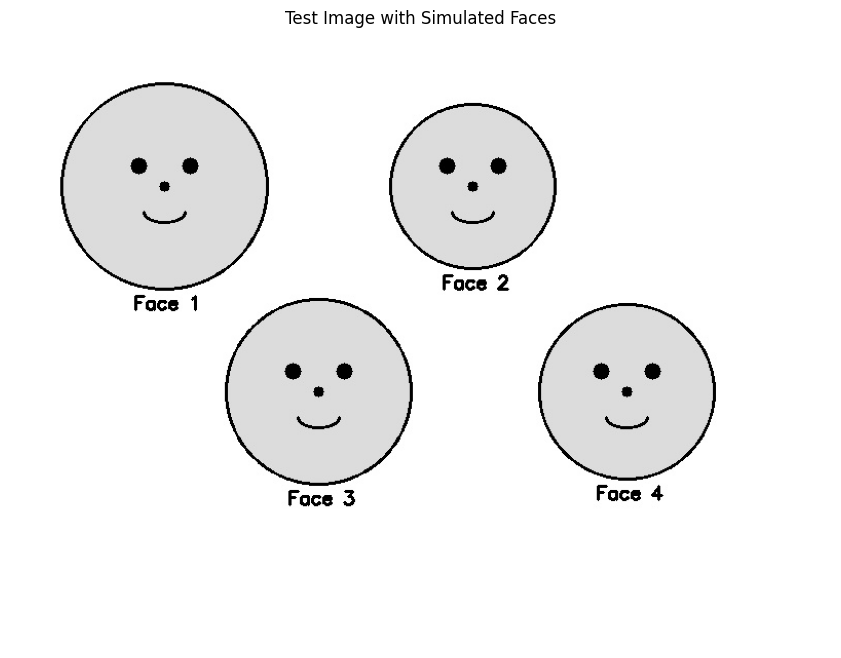

In [6]:
# Interactive testing - Display the test image
test_image = cv2.imread('data/test_images/test_faces.jpg')

plt.figure(figsize = (12 ,8))
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title('Test Image with Simulated Faces')
plt.axis('off')
plt.show();

Processing Test Image...
Processing Image: data/test_images/test_faces.jpg
Image Dimensions: 800x600
Detected 0 faces in 0.24 seconds.
Applied blur in 0.00 seconds


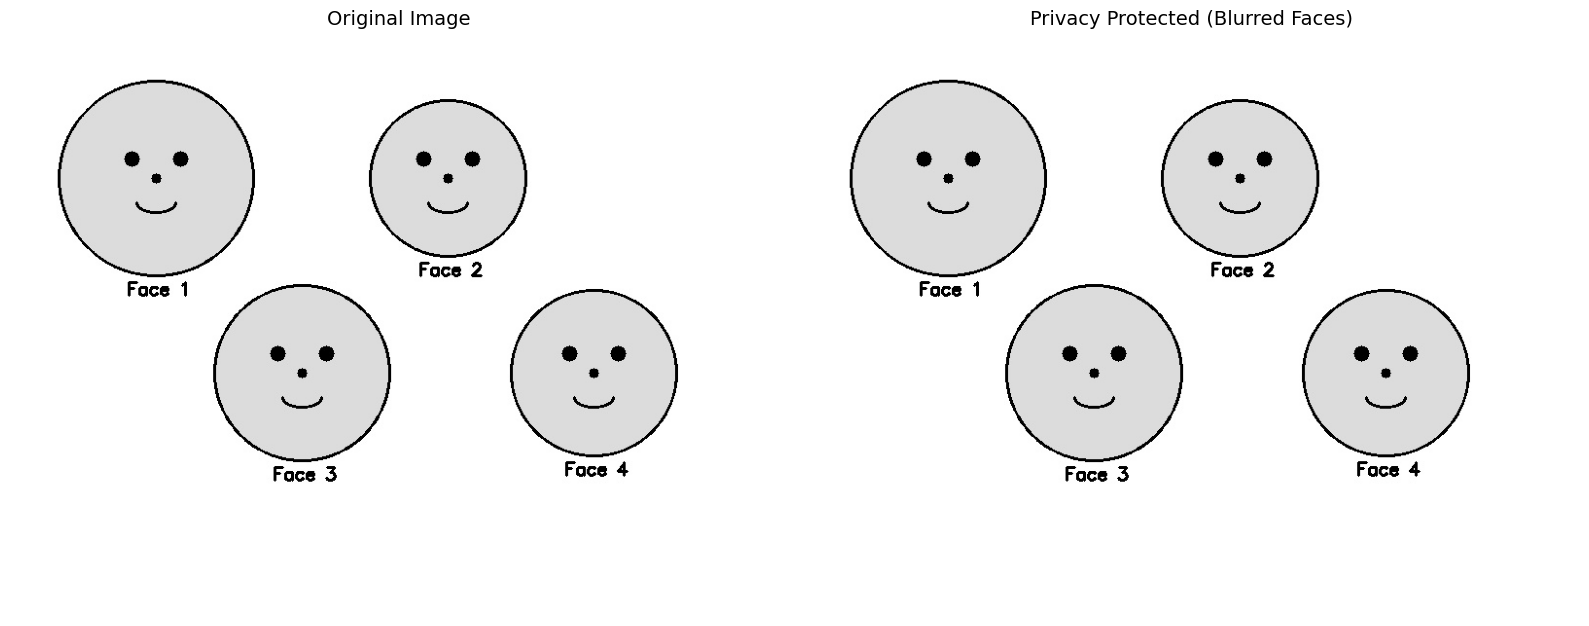

In [7]:
# Processing the Test Image
print('Processing Test Image...')
result = processor.process_and_display(test_image_path, show_detection = True)

Processing your image: data/test_images/selfie_group.jpg
Processing Image: data/test_images/selfie_group.jpg
Image Dimensions: 612x408
Detected 3 faces in 0.17 seconds.


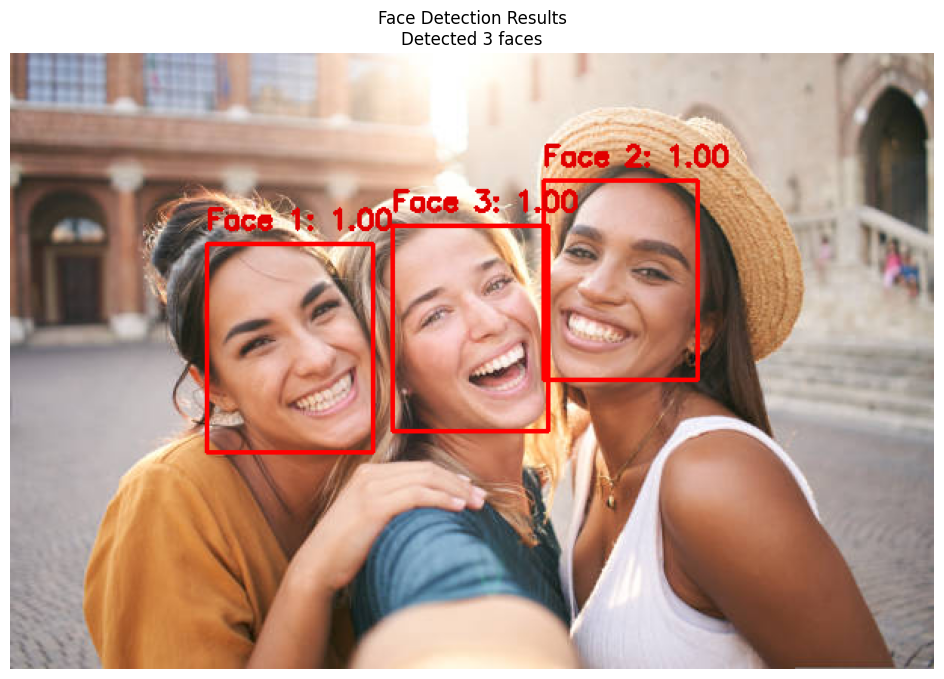

Applied blur in 0.01 seconds


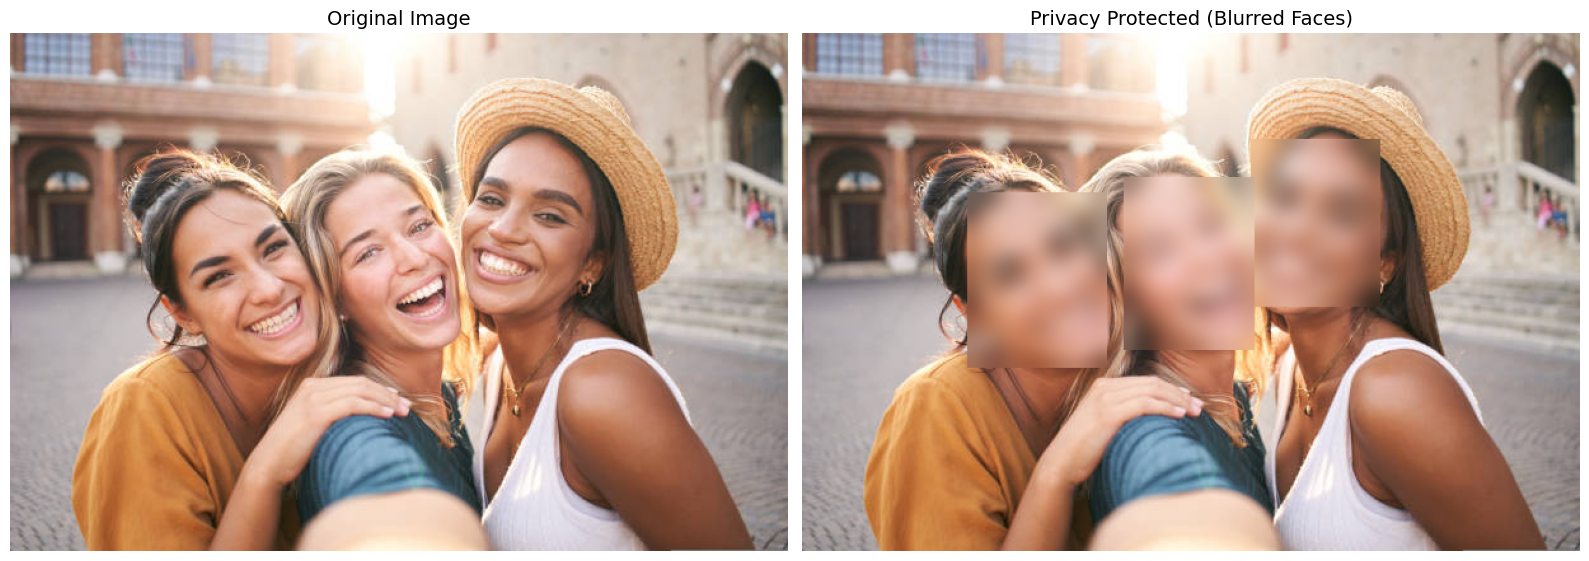

Saved blurred image to: selfie_group_blurred.jpg


In [8]:
# Processing Your Image
def process_your_image(image_path: str):
    '''Process your image'''

    if not os.path.exists(image_path):
        print(f'Image not found: {image_path}')
        return
    
    print(f'Processing your image: {image_path}')

    # Process the image
    result = processor.process_and_display(image_path, show_detection = True)

    # Save result
    output_path = Path(image_path).stem + '_blurred.jpg'
    if result is not None:
        processor.save_result(result, output_path)

    return result

# Example usage
selfie_path = 'data/test_images/selfie.jpg'
selfie_group_path = 'data/test_images/selfie_group.jpg'

result = process_your_image(image_path = selfie_group_path)

In [9]:
# Video Processing (small video files)
def process_video_sample(video_path: str, max_frames: int = 30):
    '''Process a small sample of video frames'''

    if not os.path.exists(video_path):
        print(f'Video not found: {video_path}')
        return
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f'Could not open video: {video_path}')
        return
    
    frames_processed = 0
    total_faces = 0

    print(f'Processing video sample: {video_path}')
    print(f'Will process up to {max_frames} frames')

    while frames_processed < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        faces = processor.detect_faces(frame)
        total_faces += len(faces)

        if frames_processed % 10 == 0:
            print(f'Frame {frames_processed}: {len(faces)} faces detected')

        frames_processed += 1
    
    cap.release()

    print(f'Processed {frames_processed} frames')
    print(f'Total faces detected {total_faces}')
    print(f'Average faces per frame: {total_faces / frames_processed:.2f}')

# Example usage
process_video_sample(video_path = 'data/test_videos/people.mp4', max_frames = 50)

Processing video sample: data/test_videos/people.mp4
Will process up to 50 frames
Frame 0: 10 faces detected
Frame 10: 6 faces detected
Frame 20: 6 faces detected
Frame 30: 8 faces detected
Frame 40: 6 faces detected
Processed 50 frames
Total faces detected 357
Average faces per frame: 7.14


In [10]:
# Batch Image Processing
def process_image_folder(folder_path: str, output_folder: str = 'blurred_output'):
    '''Process all images in the image folder'''

    folder = Path(folder_path)
    if not folder.exists():
        print(f'Folder not found: {folder_path}')
        return
    
    # Creating an output folder
    output_dir = Path(output_folder)
    output_dir.mkdir(exist_ok = True)

    # Supported image formats
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    # Find all images
    image_folder = Path('data/lfw-deepfunneled')
    image_files = list(image_folder.rglob('*.jpg'))  # or use *.png if needed

    for ext in image_extensions:
        image_files.extend(folder.glob(f'*{ext}'))
        image_files.extend(folder.glob(f'*{ext.upper()}'))

    if not image_files:
        print(f'No images found: {folder_path}')
        return
    
    print(f'Found {len(image_files)} images to process')
    print(f'Output folder: {output_folder}')

    total_faces = 0

    for i, image_path in enumerate(image_files):
        print(f'\nProcessing {i + 1}/{len(image_files)}: {image_path.name}')

        try:
            # Read image
            image = cv2.imread(str(image_path))
            if image is None:
                print(f'Could not read: {image_path.name}')
                continue
            
            # Detect faces
            faces = processor.detect_faces(image)
            print(f'Detected {len(faces)} faces')
            total_faces += len(faces)

            # Blur faces
            blurred_image = processor.blur_faces(image, faces)

            # Save result
            output_path = output_dir / f'{image_path.stem}_blurred{image_path.suffix}'
            cv2.imwrite(str(output_path), blurred_image)

        except Exception as e:
            print(f'Error processing {image_path.name}: {e}')

    print('\nBatch processing complete')
    print(f'Total faces detected: {total_faces}')
    print(f'Results saved to: {output_folder}')

# Example usage
process_image_folder('data/lfw-deepfunneled', 'data/output_images')

Found 13233 images to process
Output folder: data/output_images

Processing 1/13233: German_Khan_0001.jpg
Detected 1 faces

Processing 2/13233: Stefano_Gabbana_0001.jpg
Detected 1 faces

Processing 3/13233: Dragan_Covic_0001.jpg
Detected 1 faces

Processing 4/13233: Jeff_Hornacek_0001.jpg
Detected 1 faces

Processing 5/13233: Sureyya_Ayhan_0001.jpg
Detected 1 faces

Processing 6/13233: Deb_Santos_0001.jpg
Detected 1 faces

Processing 7/13233: Bob_Newhart_0001.jpg
Detected 1 faces

Processing 8/13233: Wang_Hailan_0001.jpg
Detected 1 faces

Processing 9/13233: Paul_McNulty_0002.jpg
Detected 1 faces

Processing 10/13233: Paul_McNulty_0001.jpg
Detected 1 faces

Processing 11/13233: Jimmy_Iovine_0001.jpg
Detected 1 faces

Processing 12/13233: Claudia_Pechstein_0001.jpg
Detected 1 faces

Processing 13/13233: Claudia_Pechstein_0003.jpg
Detected 1 faces

Processing 14/13233: Claudia_Pechstein_0002.jpg
Detected 1 faces

Processing 15/13233: Claudia_Pechstein_0005.jpg
Detected 1 faces

Processin